In [1]:
# Import
import os
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split  # For splitting the data
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import random

In [2]:
def custom_filter(img, ksize):
    kernel3 = np.array([[0, -1,  0],
                   [-1,  5, -1],
                    [0, -1,  0]])
    sharp_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel3)
    filteredImg = cv2.medianBlur(img, ksize=ksize)
    return filteredImg

def load_dataset(folder):
  data = []
  weap_path = folder + "/" + "weap"
  norm_path = folder + "/" + "norm"
  print(os.getcwd())
  for filename in os.listdir(weap_path):
    img = cv2.imread(weap_path + "/" + filename,0)
    img = custom_filter(img,3)
    data.append([img,1])

  for filename in os.listdir(norm_path):
    img = cv2.imread(norm_path + "/" + filename,0)
    img = custom_filter(img,3)
    data.append([img,0])
    
  return data



In [3]:
import os

current_directory = os.getcwd()
print("Current working directory:", current_directory)

data_train = load_dataset("frames/train")
data_test = load_dataset("frames/test")

Current working directory: /Users/zhangbokun/Documents/academic/4243/gunners/conv2d_models
/Users/zhangbokun/Documents/academic/4243/gunners/conv2d_models
/Users/zhangbokun/Documents/academic/4243/gunners/conv2d_models


In [4]:
#resize image to (720, 1280)
X_data = []
y_data = []
for row in data_train:
    image_data = row[0] # Access the image data
    label = row[1]
    img = cv2.resize(src = image_data, dsize=(350,250))
    img = np.expand_dims(img, axis=-1).tolist()
    X_data.append(img)
    y_data.append(label)

In [5]:

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(250, 350, 1)))  # Assuming 64x64 grayscale images
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(250, 350, 1)))  # Assuming 64x64 grayscale images
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
# Add the output layer with one neuron and 'sigmoid' activation for binary classification
model.add(Dense(1, activation='sigmoid'))
# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07, 
                                     amsgrad=False,
                                     decay=1e-4) 

In [6]:
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [7]:
# Fit the model with the training data
his = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
89/89 [==============================] - 179s 2s/step - loss: 121.6984 - accuracy: 0.5760 - val_loss: 0.6665 - val_accuracy: 0.5686
Epoch 2/10
89/89 [==============================] - 14s 157ms/step - loss: 0.6643 - accuracy: 0.6054 - val_loss: 0.6230 - val_accuracy: 0.6421
Epoch 3/10
89/89 [==============================] - 14s 155ms/step - loss: 0.6471 - accuracy: 0.6372 - val_loss: 0.5935 - val_accuracy: 0.6818
Epoch 4/10
89/89 [==============================] - 14s 155ms/step - loss: 0.6224 - accuracy: 0.6588 - val_loss: 0.5776 - val_accuracy: 0.7581
Epoch 5/10
89/89 [==============================] - 14s 155ms/step - loss: 0.6080 - accuracy: 0.6676 - val_loss: 0.5397 - val_accuracy: 0.7751
Epoch 6/10
89/89 [==============================] - 14s 156ms/step - loss: 0.5810 - accuracy: 0.6934 - val_loss: 0.5064 - val_accuracy: 0.8006
Epoch 7/10
89/89 [==============================] - 14s 156ms/step - loss: 0.5867 - accuracy: 0.6818 - val_loss: 0.4730 - val_accuracy: 0.8190

In [8]:
model.save("con2d_sharpening.h5")

/Users/zhangbokun/miniconda3/envs/python_env/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
X_test = []
y_true = []
for row in data_test:
    image_data = row[0] # Access the image data
    label = row[1]
    img = cv2.resize(src = image_data, dsize=(350,250))
    img = np.expand_dims(img, axis=-1).tolist()
    X_test.append(img)
    y_true.append(label)


In [10]:
res=model.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
final_res=[]
for i in res:
    if i<0.5:
        final_res.append(0)
    else:
        final_res.append(1)

tn, fp, fn, tp = confusion_matrix(y_true, final_res, labels=[0, 1]).ravel()

print("accuracy: ", accuracy_score(y_true,final_res))
print("f1: ",f1_score(y_true,final_res))

print("false negative rate (classify weap as norm): ", fn/(tp+fn))
print("false positive rate (classify norm as weap): ", fp/(fp+tn))

65/65 [==============================] - 2s 32ms/step
accuracy:  0.6190246257846451
f1:  0.23472356935014552
false negative rate (classify weap as norm):  0.8446726572528883
false positive rate (classify norm as weap):  0.10139318885448917


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_true, final_res, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75      1292
           1       0.48      0.16      0.23       779

    accuracy                           0.62      2071
   macro avg       0.56      0.53      0.49      2071
weighted avg       0.58      0.62      0.55      2071



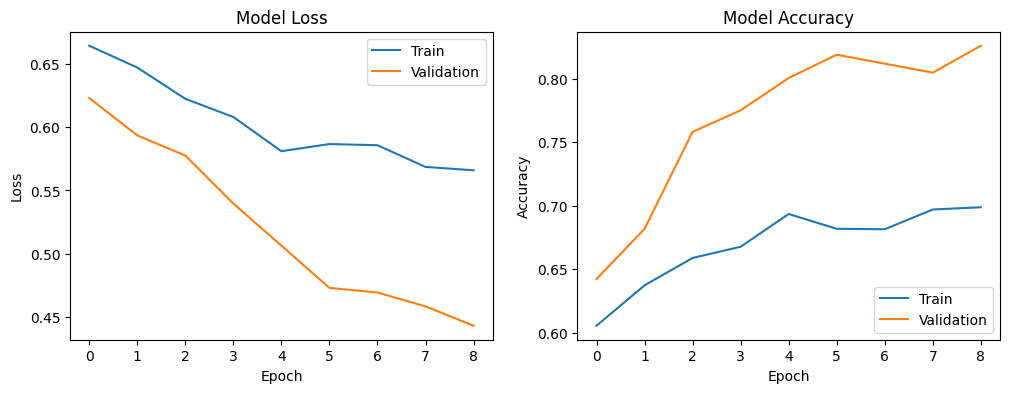

In [12]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(his.history['loss'][1:])
plt.plot(his.history['val_loss'][1:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(his.history['accuracy'][1:])
plt.plot(his.history['val_accuracy'][1:])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

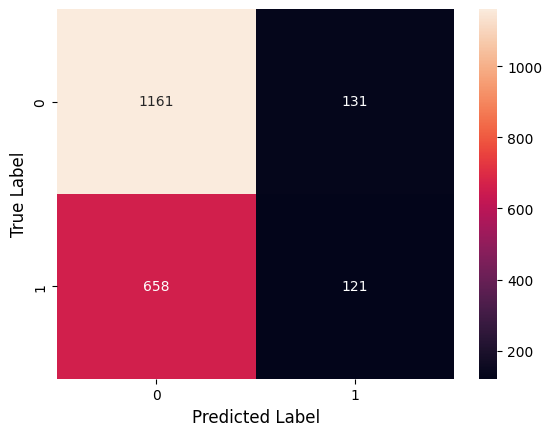

In [13]:
from sklearn import metrics
import seaborn as sns

confusion_matrix = metrics.confusion_matrix(y_true, final_res)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

ROC_AUC:  0.5269670769463113


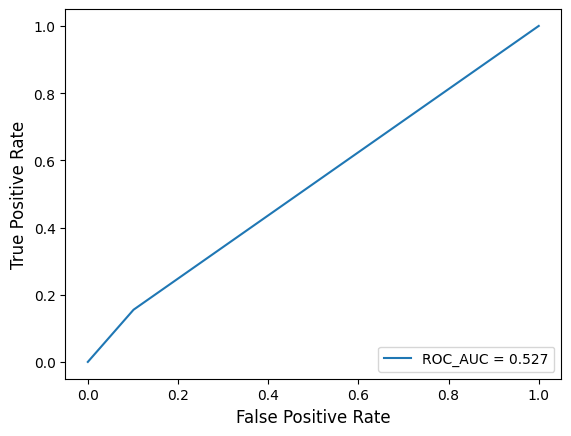

In [14]:
roc_auc = metrics.roc_auc_score(y_true, final_res)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(y_true, final_res)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()